# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [56]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.01912662812369026
 0.24368878386844595
 0.6083762412426496
 0.3617953365357077
 0.7679528498347968
 0.06491159942879388
 0.17349562245594563
 0.46689166482144195
 0.11402229654016105
 0.8754769706350316
 0.8031998361616595
 0.8557907932744273
 0.8459911029854051
 ⋮
 0.020590246545046043
 0.0405977069487109
 0.47708330405569277
 0.8902665869299531
 0.31174244941389084
 0.2976409662217554
 0.14067219706472078
 0.24459618473026878
 0.31252078287293994
 0.9019387631045815
 0.7787950851394113
 0.048182797752087114

In [57]:
sum(a)

4.9994291501217075e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [58]:
@time sum(a)

  0.006047 seconds (1 allocation: 16 bytes)


4.9994291501217075e6

In [59]:
@time sum(a)

  0.004908 seconds (1 allocation: 16 bytes)


4.9994291501217075e6

In [60]:
@time sum(a)

  0.005617 seconds (1 allocation: 16 bytes)


4.9994291501217075e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [61]:
using Pkg
Pkg.add("BenchmarkTools")

   Resolving package versions...
  No Changes to `~/GitHub/Introduction-to-Julia/Project.toml`
  No Changes to `~/GitHub/Introduction-to-Julia/Manifest.toml`


In [62]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [63]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [64]:
c_sum(a)

4.999429150121625e6

In [65]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [66]:
c_sum(a) - sum(a)  

-8.288770914077759e-8

In [67]:
≈  # alias for the `isapprox` function

isapprox (generic function with 18 methods)

In [68]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significant digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.


---

```
isapprox(x::FixedPoint, y::FixedPoint; rtol=0, atol=max(eps(x), eps(y)))
```

For FixedPoint numbers, the default criterion is that `x` and `y` differ by no more than `eps`, the separation between adjacent fixed-point numbers.


We can now benchmark the C code directly from Julia:

In [69]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 367 samples with 1 evaluation.
 Range (min … max):  12.740 ms …  16.822 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     13.596 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   13.612 ms ± 512.860 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▅▁▄    ▁▄ ▁▁▄▆▃▆ ▃▅ ▂▆▁▂▁▃ ▆█▁▅▆                           
  ▄▇▆███▅▄▃▅█████████▅██▆██████▇█████▄▆▆▅█▄▄▁▃▃▃▃▃▃▃▁▁▁▁▁▃▁▁▁▄ ▄
  12.7 ms         Histogram: frequency by time           15 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [70]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 12.740363 msec


In [71]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 12.7404

In [72]:
using Plots
gr()

Plots.GRBackend()

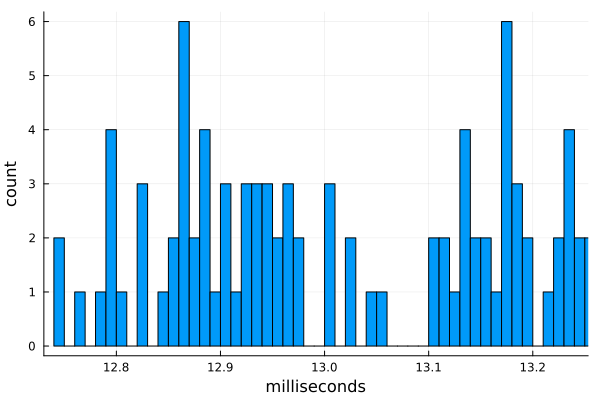

In [73]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [74]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [75]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 969 samples with 1 evaluation.
 Range (min … max):  4.404 ms …  16.716 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.889 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.145 ms ± 839.573 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▆██▅▃█▅▁▂                                                   
  ▇███████████▇▇▇▇▇▆▅▄▅▅▆▅▅▅▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃▂▃▃▂▂▁▃▃▂▂▂▂▂▂▁▂▁▂ ▄
  4.4 ms          Histogram: frequency by time        7.73 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [76]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

4.403606

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [77]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
  No Changes to `~/GitHub/Introduction-to-Julia/Project.toml`
  No Changes to `~/GitHub/Introduction-to-Julia/Manifest.toml`


In [78]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [79]:
pysum(a)

4.999429150121625e6

In [80]:
pysum(a) ≈ sum(a)

true

In [81]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  682.615 ms … 716.844 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     697.353 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   697.610 ms ±  10.821 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █         █   █       █       █     █  █                    █  
  █▁▁▁▁▁▁▁▁▁█▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  683 ms           Histogram: frequency by time          717 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [82]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 12.7404
  "Python built-in" => 682.615
  "C -ffast-math"   => 4.40361

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [83]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
  No Changes to `~/GitHub/Introduction-to-Julia/Project.toml`
  No Changes to `~/GitHub/Introduction-to-Julia/Manifest.toml`


In [84]:
Conda.add("numpy")

[ Info: Running `conda install -y numpy` in root environment


Solving environment: ...working... done

# All requested packages already installed.



In [85]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 1026 samples with 1 evaluation.
 Range (min … max):  3.845 ms …  10.854 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.686 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.865 ms ± 629.210 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

             ▇▆██▃▄▁▄                                          
  ▃▃▃▃▃▃▅▅▅██████████▆▅▆▆▆▅▆▆▅▄▅▄▃▄▄▃▄▃▄▄▃▃▃▃▃▃▃▃▁▂▃▂▂▃▂▂▁▂▁▂ ▄
  3.84 ms         Histogram: frequency by time        6.94 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [86]:
numpy_sum(a)

4.999429150121712e6

In [87]:
numpy_sum(a) ≈ sum(a)

true

In [88]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 12.7404
  "Python numpy"    => 3.84477
  "Python built-in" => 682.615
  "C -ffast-math"   => 4.40361

# 5. Python, hand-written 

In [89]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x11078b130>

In [90]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  830.661 ms …   1.055 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     976.383 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   944.344 ms ± 89.980 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █ █                                 █    ██                █  
  █▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  831 ms          Histogram: frequency by time          1.05 s <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [91]:
sum_py(a)

4.999429150121625e6

In [92]:
sum_py(a) ≈ sum(a)

true

In [93]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 12.7404
  "Python numpy"        => 3.84477
  "Python hand-written" => 830.661
  "Python built-in"     => 682.615
  "C -ffast-math"       => 4.40361

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [94]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:994

In [95]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 946 samples with 1 evaluation.
 Range (min … max):  4.299 ms …  10.905 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.132 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.271 ms ± 641.300 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

           ▁▃▄█▆▃▁                                             
  ▂▄▂▅▇▇▇▅▇███████▇▆▆▅▃▅▅▄▄▅▄▄▄▂▄▃▃▃▂▂▂▂▁▂▁▂▂▁▂▁▂▁▂▂▁▂▂▁▁▁▂▂▂ ▃
  4.3 ms          Histogram: frequency by time        8.02 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [96]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 12.7404
  "Python numpy"        => 3.84477
  "Python hand-written" => 830.661
  "Python built-in"     => 682.615
  "Julia built-in"      => 4.29915
  "C -ffast-math"       => 4.40361

# 7. Julia (hand-written) 

In [97]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [98]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 375 samples with 1 evaluation.
 Range (min … max):  11.766 ms … 24.994 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.899 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   13.316 ms ±  1.563 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▄  ▁█                                                     
  ▆▃▆█▅▆█████▇▇▆▅▄▅▄▅▃▃▃▃▃▂▁▁▁▂▃▃▂▁▁▁▁▂▂▂▁▂▁▁▁▁▂▁▁▂▂▃▁▁▁▁▂▁▁▃ ▃
  11.8 ms         Histogram: frequency by time        19.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [99]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 12.7404
  "Python numpy"        => 3.84477
  "Julia hand-written"  => 11.7657
  "Python hand-written" => 830.661
  "Python built-in"     => 682.615
  "Julia built-in"      => 4.29915
  "C -ffast-math"       => 4.40361

# 8. Julia (hand-written w. simd) 

In [100]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [101]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 951 samples with 1 evaluation.
 Range (min … max):  4.315 ms …   6.596 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.204 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.247 ms ± 319.734 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                         ▂▂▁▁▂▇█▄▃▁ ▁                          
  ▂▃▃▂▂▃▃▂▃▂▂▁▃▂▃▃▃▄▅▄▅▅▆████████████▇▆▄▄▃▄▃▃▄▃▃▃▄▄▄▃▄▃▃▂▃▃▃▃ ▄
  4.31 ms         Histogram: frequency by time        6.09 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [102]:
mysum_simd(a)

4.999429150121702e6

In [103]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 4.31458
  "C"                       => 12.7404
  "Python numpy"            => 3.84477
  "Julia hand-written"      => 11.7657
  "Python hand-written"     => 830.661
  "Python built-in"         => 682.615
  "Julia built-in"          => 4.29915
  "C -ffast-math"           => 4.40361

# Summary

In [104]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Python numpy................3.8
Julia built-in..............4.3
Julia hand-written simd.....4.3
C -ffast-math...............4.4
Julia hand-written.........11.8
C..........................12.7
Python built-in...........682.6
Python hand-written.......830.7
